### FunGRN
https://github.com/abearab/FunGRN

___
https://arboreto.readthedocs.io/en/latest/

https://nbviewer.org/github/tmoerman/arboreto/blob/master/notebooks/examples/ex_01_grnboost2_local.ipynb

[pySCENIC for bulk RNAseq #136](https://github.com/aertslab/pySCENIC/issues/136)

https://python.igraph.org/en/stable/analysis.html#clustering

#### 

http://humantfs.ccbr.utoronto.ca/index.php

In [1]:
# !wget http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt

In [2]:
from arboreto.utils import load_tf_names

In [3]:
tf_names_all = load_tf_names('TF_names_v_1.01.txt')

#### 

In [4]:
import pandas as pd
import anndata as ad

In [5]:
meta = pd.read_csv('samplesheet.csv',index_col=0)
meta.index.name=None

In [19]:
cnt  = pd.read_csv('cnt_matrix.txt', sep='\t')

In [24]:
adata = ad.AnnData(
    X   = cnt.drop(columns='name').T.loc[meta.index,:],
    obs = meta[['cell_line','treatment','replicate']],
    var = cnt[['name']]
)

adata_prdx1 = adata[adata.obs.cell_line.str.contains('A549')].copy()
adata_prdx1.obs.replicate = adata_prdx1.obs.replicate.astype(int)

In [25]:
from bulk_grn import run_genie3

In [26]:
help(run_genie3)

Help on function run_genie3 in module bulk_grn:

run_genie3(adata, subset, tf_names, name=None, outDir='GRN_results')
    Run GRN inference on a single sample
    - adata: AnnData object
    - tf_names: list of transcription factor names
    - outDir: output directory



#### sgNC1 and vehicle

In [ ]:
run_genie3(
    adata_prdx1,
    subset = [
        ('cell_line','A549_sgNC1'),
        ('treatment','vehicle')
    ],
    tf_names  = tf_names_all
) 

Job name: A549_sgNC1_vehicle
load count matrix ...
run genie3 ...
preparing dask client


#### sgNC1 and vehicle

In [ ]:
run_genie3(
    adata_prdx1,
    subset = [
        ('cell_line','A549_sgNC1'),
        ('treatment','vehicle')
    ],
    tf_names  = tf_names_all
) 

In [2]:
!python bulk_grn.py --help

In [2]:
import os
from time import time

import anndata as ad
import dask.dataframe as dd

import igraph as ig
import networkx as nx
from scripts.search import *

import arboreto
from arboreto.algo import grnboost2, genie3
from arboreto.utils import load_tf_names

In [3]:
from pyvis.network import Network

In [4]:
import blitzgsea as blitz

In [5]:
pager_dir = "/data_gilbert/home/aarab/tools/pager/"
pager_annotation_path = '/data_gilbert/home/aarab/tools/pager/annotations/human'

c5_gobp_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go.bp/c5.go.bp.v7.4.symbols.gmt'
)

## 0.TFs in CRISPRi screen

In [63]:
CRi_TFs = {
    ## threshold=3
    # rho_hl60_label=='sensitivity_hit'
    'sensitivity':[
        'ADNP','ATF5','ATF7','BPTF','CENPB','CREB1','CSRNP3','CXXC4','DMTF1','DNMT1','E2F6','ESR2','FOXA2','HIF1A','HOXD3','HSF2',
        'MTF1','MYB','NAIF1','NEUROG2','NFYC','NR1D2','PRDM15','SCRT1','SETDB1','SOX11','SPI1','THYN1','USF2','YY1','ZBTB9','ZEB2',
        'ZFX','ZNF281','ZNF514','ZNF595','ZNF644','ZNF646','ZNF81'
    ],
    # rho_hl60_label=='resistance_hit'
    'resistance':[
        'AHR','CENPT','CPEB1','E2F3','ESRRG','FOXH1','GLIS1','GRHL3','IRF2','JUNB','KDM2A','KLF16','MAX','MBD6','NFIB','NKRF','PHF20',
        'PHF21A','PURG','RBCK1','REST','RFX1','SKIL','SNAPC2','SPEN','TBP','TET2','TFAP4','TFDP1','THAP11','ZBTB20','ZFP28','ZNF131',
        'ZNF195','ZNF292','ZNF326','ZNF354A','ZNF44','ZNF574','ZNF628','ZNF768'
    ]
}

## 1. Load the input data

#### exp

In [6]:
exp_counts = pd.read_csv('DAC/RNA-seq/exp/deseq2_raw_counts.txt',sep='\t')

In [7]:
exp_counts_norm = pd.read_csv('DAC/RNA-seq/exp/deseq2_norm.txt',sep='\t')

In [8]:
delta_exp = pd.read_csv('DAC/RNA-seq/exp/delta_exp_table.txt',sep='\t')

In [9]:
# meta
lines = ['HL-60'] * 12 + ["KG-1"] * 6 + ["MOLM-14"] * 6 + ["OCI-AML2"] * 6 + ["OCI-AML3"] * 6 + ["THP-1"] * 6

# meta
conds = (
    ['Decitabine'] * 2 + ['DMSO'] * 2) * 3 + (['Decitabine'] * 3 + ['DMSO'] * 3) * 5

reps = (['rep1', 'rep2'] * 6) + (['rep1', 'rep2', 'rep3'] * 10)

hours = (['120h'] * 4 + ['6h'] * 4 + ['72h'] * 4) + (['72h'] * 30)

meta = pd.DataFrame({
    'line': lines,
    'cond': conds,
    'time': hours,
    'reps': reps
})

# Set row names (assuming 'counts' variable exists)
meta.index = exp_counts.drop('name',axis=1).columns

In [10]:
edata = ad.AnnData(
    exp_counts.drop('name',axis=1).T,
    obs=meta,
    var=exp_counts[['name']]
)

In [11]:
edata.obs.head(15)

,line,cond,time,reps
hl60_120h_t_1,HL-60,Decitabine,120h,rep1
hl60_120h_t_2,HL-60,Decitabine,120h,rep2
hl60_120h_u_1,HL-60,DMSO,120h,rep1
hl60_120h_u_2,HL-60,DMSO,120h,rep2
hl60_6h_t_1,HL-60,Decitabine,6h,rep1
hl60_6h_t_2,HL-60,Decitabine,6h,rep2
hl60_6h_u_1,HL-60,DMSO,6h,rep1
hl60_6h_u_2,HL-60,DMSO,6h,rep2
hl60_72h_t_1,HL-60,Decitabine,72h,rep1
hl60_72h_t_2,HL-60,Decitabine,72h,rep2


#### stbl

In [12]:
stbl_counts = pd.read_csv('DAC/RNA-seq/stbl/normalized_stbl_count_table.txt',sep='\t').fillna(0)
stbl_counts = stbl_counts[['name'] + exp_counts.drop('name',axis=1).columns.to_list()]

In [13]:
delta_stbl = pd.read_csv('DAC/RNA-seq/stbl/delta_stbl_table.txt',sep='\t')

In [14]:
# meta
lines = ['HL-60'] * 12 + ["KG-1"] * 6 + ["MOLM-14"] * 6 + ["OCI-AML2"] * 6 + ["OCI-AML3"] * 6 + ["THP-1"] * 6

# meta
conds = (
    ['Decitabine'] * 2 + ['DMSO'] * 2) * 3 + (['Decitabine'] * 3 + ['DMSO'] * 3) * 5

reps = (['rep1', 'rep2'] * 6) + (['rep1', 'rep2', 'rep3'] * 10)

hours = (['120h'] * 4 + ['6h'] * 4 + ['72h'] * 4) + (['72h'] * 30)

meta = pd.DataFrame({
    'line': lines,
    'cond': conds,
    'time': hours,
    'reps': reps
})

# Set row names (assuming 'counts' variable exists)
meta.index = stbl_counts.drop('name',axis=1).columns

In [15]:
sdata = ad.AnnData(
    stbl_counts.drop('name',axis=1).T,
    obs=meta,
    var=stbl_counts[['name']]
)

In [16]:
sdata.obs.head(15)

,line,cond,time,reps
hl60_120h_t_1,HL-60,Decitabine,120h,rep1
hl60_120h_t_2,HL-60,Decitabine,120h,rep2
hl60_120h_u_1,HL-60,DMSO,120h,rep1
hl60_120h_u_2,HL-60,DMSO,120h,rep2
hl60_6h_t_1,HL-60,Decitabine,6h,rep1
hl60_6h_t_2,HL-60,Decitabine,6h,rep2
hl60_6h_u_1,HL-60,DMSO,6h,rep1
hl60_6h_u_2,HL-60,DMSO,6h,rep2
hl60_72h_t_1,HL-60,Decitabine,72h,rep1
hl60_72h_t_2,HL-60,Decitabine,72h,rep2


#### 

http://humantfs.ccbr.utoronto.ca/index.php

In [17]:
# !wget http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt

In [18]:
tf_names_all = load_tf_names('annotations/TF_names_v_1.01.txt')

## 2. Launch gene regulatory network inference

In [29]:
!mkdir -p GRN_results/

In [32]:
def run_genie3(adata,cell_line,treatment,time_point,tf_names=tf_names_all,outDir='GRN_results'):
    t0 = time()
    name = '_'.join([cell_line,treatment,time_point])
    print(f"Job name: {name}")
    
    tf_names = list(set(tf_names_all) & set(adata.var.name))

    print(f"load count matrix ...")
    ex_matrix = adata[
        adata.obs.line.eq(cell_line) & 
        adata.obs.cond.eq(treatment) & 
        adata.obs.time.eq(time_point)
    ].to_df()
    ex_matrix.columns = adata.var['name'].to_list()
    
    print(f"run genie3 ...")
    network = genie3(expression_data=ex_matrix,
                        verbose=True,
                        tf_names=tf_names
                       )

    print(f"save network to file ...")
    network.to_pickle(f"{outDir}/{name}.pkl")
    
    print("done in %0.3fs" % (time() - t0))

### co-exp network

In [51]:
!mkdir -p GRN_results/exp

#### HL60 – DMSO

In [ ]:
run_genie3(
    edata,
    cell_line="HL-60",treatment= 'DMSO',time_point='6h'
)

run_genie3(
    edata,
    cell_line="HL-60",treatment= 'DMSO',time_point='72h'
)

run_genie3(
    edata,
    cell_line="HL-60",treatment= 'DMSO',time_point='120h'
)

#### HL60 – Decitabine

In [ ]:
run_genie3(
    edata,
    cell_line="HL-60",treatment= 'Decitabine',time_point='6h'
)

run_genie3(
    edata,
    cell_line="HL-60",treatment= 'Decitabine',time_point='72h'
)

run_genie3(
    edata,
    cell_line="HL-60",treatment= 'Decitabine',time_point='120h'
)

#### KG-1

In [ ]:
run_genie3(
    edata,
    cell_line="KG-1",
    treatment='Decitabine',
    time_point='72h'
)

Job name: KG-1_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 23.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' R

In [44]:
run_genie3(
    edata,
    cell_line="KG-1",
    treatment='DMSO',
    time_point='72h'
)

'WARNING: infer_data failed for target AHRR' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (8/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (9/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retry (10/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target AHRR' Retr

shutting down client and local cluster


2023-08-13 05:12:57,561 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing


finished
save network to file ...
done in 30719.733s


#### MOLM-14

In [46]:
run_genie3(
    edata,
    cell_line="MOLM-14",
    treatment='Decitabine',
    time_point='72h'
)

Job name: MOLM-14_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 22.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' R

shutting down client and local cluster


2023-08-13 13:40:55,167 - distributed.nanny - WARNING - Worker process still alive after 3.1999981689453127 seconds, killing
2023-08-13 13:40:55,170 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing


finished
save network to file ...
done in 30475.903s


In [47]:
run_genie3(
    edata,
    cell_line="MOLM-14",
    treatment='DMSO',
    time_point='72h'
)

Job name: MOLM-14_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 22.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' R

shutting down client and local cluster


2023-08-13 19:27:31,559 - distributed.nanny - WARNING - Worker process still alive after 3.1999978637695317 seconds, killing
2023-08-13 19:27:31,561 - distributed.nanny - WARNING - Worker process still alive after 3.1999978637695317 seconds, killing
2023-08-13 19:27:31,562 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-08-13 19:27:31,564 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2023-08-13 19:27:31,565 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-08-13 19:27:31,566 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2023-08-13 19:27:31,567 - distributed.nanny - WARNING - Worker process still alive after 3.1999980163574224 seconds, killing
2023-08-13 19:27:31,570 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing


finished
save network to file ...
done in 20799.072s


#### OCI-AML2

In [48]:
run_genie3(
    edata,
    cell_line="OCI-AML2",
    treatment='Decitabine',
    time_point='72h'
)

Job name: OCI-AML2_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 22.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' R

shutting down client and local cluster


2023-08-14 00:30:31,314 - distributed.nanny - WARNING - Worker process still alive after 3.1999978637695317 seconds, killing
2023-08-14 00:30:31,316 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2023-08-14 00:30:31,318 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-08-14 00:30:31,319 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-08-14 00:30:31,321 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-08-14 00:30:31,323 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing


finished
save network to file ...
done in 18175.712s


In [49]:
run_genie3(
    edata,
    cell_line="OCI-AML2",
    treatment='DMSO',
    time_point='72h'
)

Job name: OCI-AML2_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 22.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' R

shutting down client and local cluster


2023-08-14 05:55:39,658 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing


finished
save network to file ...
done in 19505.975s


#### OCI-AML3

In [50]:
run_genie3(
    edata,
    cell_line="OCI-AML3",
    treatment='Decitabine',
    time_point='72h'
)

Job name: OCI-AML3_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 23.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
'WARNING: infer_data failed for target ZNF883' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF883' R

shutting down client and local cluster


2023-08-14 14:14:50,916 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing


finished
save network to file ...
done in 29950.600s


In [ ]:
run_genie3(
    edata,
    cell_line="OCI-AML3",
    treatment='DMSO',
    time_point='72h'
)

Job name: OCI-AML3_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 22.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


#### THP-1

In [ ]:
run_genie3(
    edata,
    cell_line="THP-1",
    treatment='Decitabine',
    time_point='72h'
)

In [ ]:
run_genie3(
    edata,
    cell_line="THP-1",
    treatment='DMSO',
    time_point='72h'
)

### co-stbl network

In [33]:
!mkdir -p GRN_results/stbl

#### HL60 – DMSO

In [34]:
run_genie3(
    sdata,
    cell_line="HL-60",treatment= 'DMSO',time_point='6h',
    outDir='GRN_results/stbl'
)

run_genie3(
    sdata,
    cell_line="HL-60",treatment= 'DMSO',time_point='72h',
    outDir='GRN_results/stbl'
)

run_genie3(
    sdata,
    cell_line="HL-60",treatment= 'DMSO',time_point='120h',
    outDir='GRN_results/stbl'
)

Job name: HL-60_DMSO_6h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1382.498s
Job name: HL-60_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1371.685s
Job name: HL-60_DMSO_120h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1373.661s


#### HL60 – Decitabine

In [35]:
run_genie3(
    sdata,
    cell_line="HL-60",treatment= 'Decitabine',time_point='6h',
    outDir='GRN_results/stbl'
)

run_genie3(
    sdata,
    cell_line="HL-60",treatment= 'Decitabine',time_point='72h',
    outDir='GRN_results/stbl'
)

run_genie3(
    sdata,
    cell_line="HL-60",treatment= 'Decitabine',time_point='120h',
    outDir='GRN_results/stbl'
)

Job name: HL-60_Decitabine_6h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1370.268s
Job name: HL-60_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1335.219s
Job name: HL-60_Decitabine_120h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1306.900s


#### KG-1

In [36]:
run_genie3(
    sdata,
    cell_line="KG-1",
    treatment='Decitabine',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: KG-1_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1462.214s


In [37]:
run_genie3(
    sdata,
    cell_line="KG-1",
    treatment='DMSO',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: KG-1_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1503.870s


#### MOLM-14

In [38]:
run_genie3(
    sdata,
    cell_line="MOLM-14",
    treatment='Decitabine',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: MOLM-14_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1500.469s


In [39]:
run_genie3(
    sdata,
    cell_line="MOLM-14",
    treatment='DMSO',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: MOLM-14_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1497.023s


#### OCI-AML2

In [40]:
run_genie3(
    sdata,
    cell_line="OCI-AML2",
    treatment='Decitabine',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: OCI-AML2_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1499.451s


In [41]:
run_genie3(
    sdata,
    cell_line="OCI-AML2",
    treatment='DMSO',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: OCI-AML2_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1504.494s


#### OCI-AML3

In [42]:
run_genie3(
    sdata,
    cell_line="OCI-AML3",
    treatment='Decitabine',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: OCI-AML3_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1499.465s


In [43]:
run_genie3(
    sdata,
    cell_line="OCI-AML3",
    treatment='DMSO',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: OCI-AML3_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1494.794s


#### THP-1

In [44]:
run_genie3(
    sdata,
    cell_line="THP-1",
    treatment='Decitabine',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: THP-1_Decitabine_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1491.573s


In [45]:
run_genie3(
    sdata,
    cell_line="THP-1",
    treatment='DMSO',
    time_point='72h',
    outDir='GRN_results/stbl'
)

Job name: THP-1_DMSO_72h
load count matrix ...
run genie3 ...
preparing dask client
parsing input
creating dask graph
8 partitions
computing dask graph
shutting down client and local cluster
finished
save network to file ...
done in 1495.017s


## 3. Build full graph

In [58]:
def build_graph(df,verbose=True):
    G = ig.Graph.TupleList(df[['TF','target','importance']].itertuples(index=False), directed=True, weights=True)
    G.es['cellline'] = df['cellline'].to_list()
    G.es['treatment'] = df['treatment'].to_list()
    G.es['weight'] = df['importance'].to_list()

    if verbose: get_graph_features(G)

    return G


def filt_by_importance(df,q):
    df_filt = df[df.importance.gt(df.importance.quantile(q))].reset_index(drop=True)
    print(f'\t# of edges: {df.shape[0]} --filter(top{int((1-q)*100)}%)--> {df_filt.shape[0]}')
    return df_filt


def read_grn_as_ddf(adata,modality,q=0.99):
    grn_data = {}

    for cell_line in adata.obs.line.unique():
        print(cell_line)

        print('\tDecitabine@72h')
        grn_data[f'{cell_line}_DAC']  = filt_by_importance(pd.read_pickle(f'GRN_results/{modality}/{cell_line}_Decitabine_72h.pkl'),q=q)

        print('\tDMSO@72h')
        grn_data[f'{cell_line}_DMSO'] = filt_by_importance(pd.read_pickle(f'GRN_results/{modality}/{cell_line}_DMSO_72h.pkl'),q=q)

    grn_df = pd.concat(grn_data).reset_index().drop(columns='level_1').rename(columns={'level_0':'condition'})
    grn_ddf = dd.from_pandas(grn_df, npartitions=8)
    
    return grn_ddf

In [125]:
def ann_graph(G, geneset=None, geneset2=None):
    G.vs["color"] = ["lightgray" for node in G.vs]
    G.es["color"] = ["lightgray" if treat == 0 else 'darkblue' for treat in G.es['treatment']]
    
    if geneset: 
        for gene in geneset:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = 'yellow'
            
    if geneset2: 
        for gene in geneset2:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = "lightblue"
            
            
            
    return G

def plot_graph(G, geneset=None, geneset2=None, weights=None, initial=None, layout="kk", vs_label_size=6, vs_width = 0.1, vs_size=35, b1=500, b2=500):
    """visualising graph data
    """
    G = ann_graph(G,geneset=geneset, geneset2=geneset2)

    return ig.plot(
        G.community_label_propagation(weights=weights, initial=initial),
        layout=G.layout(layout),
        vertex_label=G.vs["name"],
        vertex_color=G.vs["color"],
        vertex_label_size=vs_label_size, 
        vertex_size=vs_size,
        vertex_width=vs_width,
        edge_color = G.es["color"],
        edge_arrow_size = .1,
        # edge_width = G.es["weight"] * 10**7,
        bbox=(b1, b2), margin=60,
        mark_groups=True
    )

In [60]:
def label_graph_nodes_by_ScreenPro_hits(G,reference,label):
    label_list = []
    for name in G.vs['name']:
        if name in reference['sensitivity']:
            label_list.append(-1)
        elif name in reference['resistance']:
            label_list.append(1)
        else:
            label_list.append(0)
            
    G.vs[label] = label_list

### co-exp network

read `grn` files

In [23]:
expGRN_ddf = read_grn_as_ddf(edata,'exp')

HL-60
	Decitabine@72h
	# of edges: 11974389 --filter(top1%)--> 114218
	DMSO@72h
	# of edges: 12053240 --filter(top1%)--> 120525
KG-1
	Decitabine@72h
	# of edges: 22404808 --filter(top1%)--> 224048
	DMSO@72h
	# of edges: 22191938 --filter(top1%)--> 220092
MOLM-14
	Decitabine@72h
	# of edges: 20924434 --filter(top1%)--> 206887
	DMSO@72h
	# of edges: 20638866 --filter(top1%)--> 202614
OCI-AML2
	Decitabine@72h
	# of edges: 21882627 --filter(top1%)--> 218827
	DMSO@72h
	# of edges: 20549310 --filter(top1%)--> 205107
OCI-AML3
	Decitabine@72h
	# of edges: 23090210 --filter(top1%)--> 230828
	DMSO@72h
	# of edges: 21491621 --filter(top1%)--> 214710
THP-1
	Decitabine@72h
	# of edges: 23569321 --filter(top1%)--> 235693
	DMSO@72h
	# of edges: 22585092 --filter(top1%)--> 223668


In [24]:
expGRN_ddf['treatment'] = expGRN_ddf.condition.str.split('_').str[1].eq('DAC').astype(int)
expGRN_ddf['cellline'] = expGRN_ddf.condition.str.split('_').str[0]

___

#### full graph – dataframe

In [52]:
expGRN_ddf.reset_index(drop=True).to_csv('GRN_results/exp_grn_ddf', compression='gzip')

['/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/0.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/1.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/2.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/3.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/4.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/5.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/6.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/exp_grn_ddf/7.part']

___

#### ...

In [71]:
expGRN_ddf = dd.read_csv('GRN_results/exp_grn_ddf/*.part',blocksize=None,compression='gzip').set_index('Unnamed: 0')
expGRN_ddf.index.name = None

In [61]:
expGRN_gr = build_graph(expGRN_ddf.compute())

IGRAPH DNW- 43760 2417217 -- 
+ attr: name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 43760
Number of edges in the graph 2417217
Is the graph directed: True
Maximum degree in the graph: 4837
Node name with Maximum degree: ['ZNF215']


In [64]:
label_graph_nodes_by_ScreenPro_hits(expGRN_gr,reference=CRi_TFs,label='CRISPRi_TF')

In [65]:
set(expGRN_gr.es['treatment'])

{0, 1}

### co-stbl network

read `grn` files

In [31]:
stblGRN_ddf = read_grn_as_ddf(sdata,'stbl',q=.99)

HL-60
	Decitabine@72h
	# of edges: 420382 --filter(top1%)--> 4199
	DMSO@72h
	# of edges: 409031 --filter(top1%)--> 4076
KG-1
	Decitabine@72h
	# of edges: 491654 --filter(top1%)--> 4916
	DMSO@72h
	# of edges: 488448 --filter(top1%)--> 4885
MOLM-14
	Decitabine@72h
	# of edges: 492876 --filter(top1%)--> 4929
	DMSO@72h
	# of edges: 495795 --filter(top1%)--> 4956
OCI-AML2
	Decitabine@72h
	# of edges: 492544 --filter(top1%)--> 4926
	DMSO@72h
	# of edges: 489927 --filter(top1%)--> 4900
OCI-AML3
	Decitabine@72h
	# of edges: 496058 --filter(top1%)--> 4961
	DMSO@72h
	# of edges: 494512 --filter(top1%)--> 4946
THP-1
	Decitabine@72h
	# of edges: 492092 --filter(top1%)--> 4921
	DMSO@72h
	# of edges: 490107 --filter(top1%)--> 4902


In [32]:
stblGRN_ddf['treatment'] = stblGRN_ddf.condition.str.split('_').str[1].eq('DAC').astype(int)
stblGRN_ddf['cellline'] = stblGRN_ddf.condition.str.split('_').str[0]

___

In [33]:
# l.compute().hist(bins=100)

#### full graph – dataframe

In [34]:
# stblGRN_ddf.groupby(['cellline','treatment']).size().compute()

In [74]:
stblGRN_ddf.reset_index(drop=True).to_csv('GRN_results/stbl_grn_ddf', compression='gzip')

['/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/0.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/1.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/2.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/3.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/4.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/5.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/6.part',
 '/data_gilbert/home/aarab/AML/Decitabine-treatment/GRN_results/stbl_grn_ddf/7.part']

___

READ 

In [75]:
stblGRN_ddf = dd.read_csv('GRN_results/stbl_grn_ddf/*.part',blocksize=None,compression='gzip').set_index('Unnamed: 0')
stblGRN_ddf.index.name = None

In [76]:
stblGRN_ddf

,condition,TF,target,importance,treatment,cellline
npartitions=8,,,,,,
0,object,object,object,float64,int64,object
856,...,...,...,...,...,...
...,...,...,...,...,...,...
6039,...,...,...,...,...,...
7189,...,...,...,...,...,...


In [77]:
stblGRN_gr = build_graph(stblGRN_ddf.compute())

IGRAPH DNW- 2776 57517 -- 
+ attr: name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 2776
Number of edges in the graph 57517
Is the graph directed: True
Maximum degree in the graph: 499
Node name with Maximum degree: ['FOXO3']


In [78]:
label_graph_nodes_by_ScreenPro_hits(stblGRN_gr,reference=CRi_TFs,label='CRISPRi_TF')

In [79]:
set(stblGRN_gr.es['treatment'])

{0, 1}

## 4. Subgraphs

#### HL-60 subgraph

In [80]:
expGRN_hl60_gr = expGRN_gr.es.select(cellline='HL-60').subgraph()

get_graph_features(expGRN_hl60_gr)

IGRAPH DNW- 30346 234743 -- 
+ attr: CRISPRi_TF (v), name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 30346
Number of edges in the graph 234743
Is the graph directed: True
Maximum degree in the graph: 354
Node name with Maximum degree: ['AHRR']


In [105]:
stblGRN_hl60_gr = stblGRN_gr.es.select(cellline='HL-60').subgraph()

get_graph_features(stblGRN_hl60_gr)

IGRAPH DNW- 1523 8275 -- 
+ attr: CRISPRi_TF (v), name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 1523
Number of edges in the graph 8275
Is the graph directed: True
Maximum degree in the graph: 119
Node name with Maximum degree: ['MXI1']


### subgraph by CRISPRi hits

In [81]:
# sensitivity graph
expGRN_hl60_gr.vs.select(CRISPRi_TF=-1).subgraph()

In [82]:
# resistance graph
expGRN_hl60_gr.vs.select(CRISPRi_TF=1).subgraph()

### An enriched GO

> ### [chondrocyte differentiation](https://www.ebi.ac.uk/QuickGO/term/GO:0002062)
> The process in which a chondroblast acquires specialized structural and/or functional features of a chondrocyte. A chondrocyte is a polymorphic cell that forms cartilage.

In [106]:
# labels = [
#     ## GOBP_CHONDROCYTE_DIFFERENTIATION
#     # The process in which a chondroblast acquires specialized structural and/or functional features of a chondrocyte. A chondrocyte is a polymorphic cell that forms cartilage.
#     "COL11A1","CHADL","COL2A1","ADAMTS7","CCN3","NKX3-2","ACVRL1","PTH1R",
#     "SOX5","AXIN2","MDK","SHOX2","BMPR1B","GDF6","MATN1","BMPR1A","GLI2",
#     "WNT9A","FGFR3","SULF2","SMPD3","IHH","BMP4","CCN4","GDF5","EXT1","TRPS1",
#     "COL27A1","WNT5B"
# ]

In [107]:
geneset = c5_gobp_gmt['GOBP_CHONDROCYTE_DIFFERENTIATION']

### co-exp network

In [108]:
expGRN_hl60_go_gr = filter_graph_by_nodes_BFS(
    expGRN_hl60_gr,
    [l for l in geneset if l in expGRN_hl60_gr.vs['name']],
    max_distance=1
)

IGRAPH DNW- 4007 20634 -- 
+ attr: CRISPRi_TF (v), name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 4007
Number of edges in the graph 20634
Is the graph directed: True
Maximum degree in the graph: 244
Node name with Maximum degree: ['NFIB']


___

In [126]:
subgr1 = filter_graph_by_nodes_BFS(
    expGRN_hl60_go_gr,
    ['RUNX2'],
    # ['SOX6'],
    max_distance=1
)

IGRAPH DNW- 181 208 -- 
+ attr: CRISPRi_TF (v), name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 181
Number of edges in the graph 208
Is the graph directed: True
Maximum degree in the graph: 180
Node name with Maximum degree: ['RUNX2']


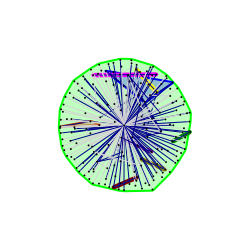

In [127]:
subgr = subgr1

plot_graph(
    subgr,
    weights='treatment',
    # initial='CRISPRi_TF',
    vs_size = 1,
    vs_width = 1,
    vs_label_size = 0,
    geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    # geneset2=[l for l in labels if l in grn_res_gr.vs['name']]
    # layout='circle',#)
    b1=250,b2=250,
)
# )

1.1. igraph_isomorphic — Are two graphs isomorphic?


In [128]:
subgr1.es.select(treatment=0).subgraph().isomorphic(
    subgr1.es.select(treatment=1).subgraph()
)

False

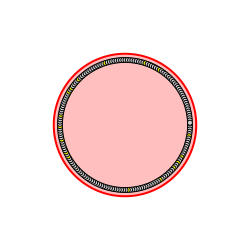

In [129]:
subgr = ig.intersection([
    subgr1.es.select(treatment=0).subgraph(),
    subgr1.es.select(treatment=1).subgraph()
])

plot_graph(
    subgr,
    weights='treatment',
    initial='CRISPRi_TF',
    vs_size = 5,
    vs_width = 5,
    vs_label_size = 0,
    geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    # geneset2=[l for l in labels if l in grn_res_gr.vs['name']]
    layout='circle',#)
    b1=250,b2=250,
)
# )

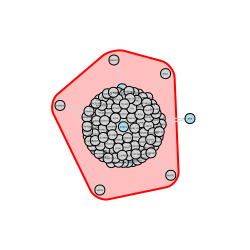

In [130]:
subgr = subgr1.es.select(treatment=0).subgraph()

plot_graph(
    subgr,
    initial='CRISPRi_TF',
    vs_size = 10,
    vs_width = 10,
    vs_label_size = 2,
    # geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    geneset2=[l for l in geneset if l in subgr.vs['name']],
    layout='kamada_kawai',#)
    b1=250,b2=250,
)
# )

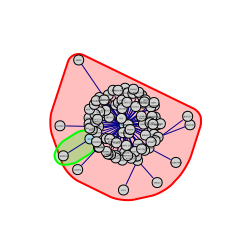

In [131]:
subgr = subgr1.es.select(treatment=1).subgraph()

plot_graph(
    subgr,
    initial='CRISPRi_TF',
    vs_size = 10,
    vs_width = 10,
    vs_label_size = 2,
    # geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    geneset2=[l for l in geneset if l in subgr.vs['name']],
    layout='kamada_kawai',#)
    b1=250,b2=250,
)

> #### Aberrant activity of NKL homeobox gene NKX3-2 in a T-ALL subset
> - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5944955/

> https://www.cell.com/heliyon/pdf/S2405-8440(22)03944-5.pdf
> > Bapx1, also known as Nkx3.2, is a suppressive factor of chondrocyte hypertrophy [117]. https://pubmed.ncbi.nlm.nih.gov/10886375/

> https://doi.org/10.1016/j.biopha.2017.02.093
> > #### DNA methylation changes during chondrocyte differentiation
Although less is studied about the epigenetic changes of MSCs during chondrocyte differentiation, previous studies based on examination of individual gene promoter have proposed a little alteration in DNA methylation with dramatic effects on CpG sites, gene expression, and diseases. In cartilage, DNMT1 and DNMT3A are assumed to be responsible for DNA methylation pattern of chondrocytes, while DNMT3B is transcribed at low levels [85]. According to an early investigation on chick embryos, DNA



In [ ]:
nt = Network('2500px', '1500px')

In [138]:
nt.from_nx(ann_graph(
    subgr,geneset=[g for g in subgr.vs['name'] if g in tf_names_all]
).to_networkx())

In [139]:
# nt.show('nx.html')

> #### HSF2 – Heat Shock Transcription Factor 2

#### sox11

> Prognostic significance of SOX2, SOX3, SOX11, SOX14 and SOX18 gene expression in adult de novo acute myeloid leukemia
> - https://pubmed.ncbi.nlm.nih.gov/29428447/


> DNA methylation and histone modifications regulate SOX11 expression in lymphoid and solid cancer cells
> - https://bmccancer.biomedcentral.com/articles/10.1186/s12885-015-1208-y

### co-stbl network

In [152]:
stblGRN_hl60_go_gr = filter_graph_by_nodes_BFS(
    stblGRN_hl60_gr,
    [l for l in geneset if l in stblGRN_hl60_gr.vs['name']],
    max_distance=1
)

IGRAPH DNW- 348 1954 -- 
+ attr: CRISPRi_TF (v), name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 348
Number of edges in the graph 1954
Is the graph directed: True
Maximum degree in the graph: 106
Node name with Maximum degree: ['MEF2D']


___

In [179]:
subgr1 = filter_graph_by_nodes_BFS(
    stblGRN_hl60_go_gr,
    ['RUNX2'],
    # ['SOX6'],
    max_distance=2
)

IGRAPH DNW- 209 1174 -- 
+ attr: CRISPRi_TF (v), name (v), cellline (e), treatment (e), weight (e) 

Number of vertices in the graph: 209
Number of edges in the graph 1174
Is the graph directed: True
Maximum degree in the graph: 65
Node name with Maximum degree: ['TRPS1']


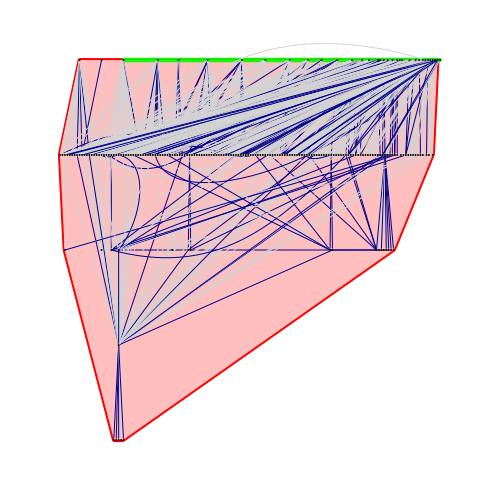

In [200]:
subgr = subgr1

plot_graph(
    subgr,
    # weights='treatment',
    initial='CRISPRi_TF',
    vs_size = 1,
    vs_width = 1,
    vs_label_size = 0,
    geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    # geneset2=[l for l in labels if l in grn_res_gr.vs['name']]
    layout='tree',#)
    # b1=250,b2=250,
)
# )

1.1. igraph_isomorphic — Are two graphs isomorphic?


In [181]:
subgr1.es.select(treatment=0).subgraph().isomorphic(
    subgr1.es.select(treatment=1).subgraph()
)

False

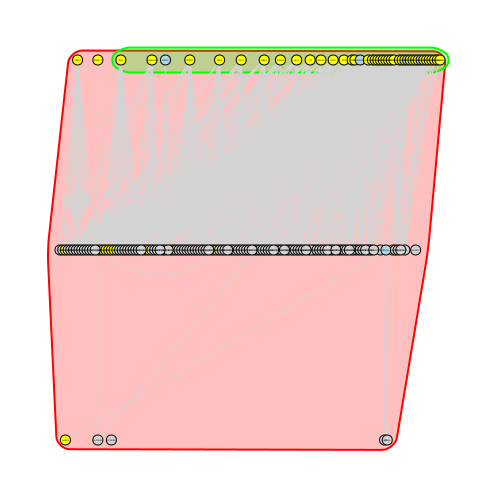

In [198]:
subgr = subgr1.es.select(treatment=0).subgraph()

plot_graph(
    subgr,
    initial='CRISPRi_TF',
    vs_size = 10,
    vs_width = 10,
    vs_label_size = 2,
    geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    geneset2=[l for l in geneset if l in subgr.vs['name']],
    # layout='kamada_kawai',#)
    layout='tree',#)
    # b1=250,b2=250,
)
# )

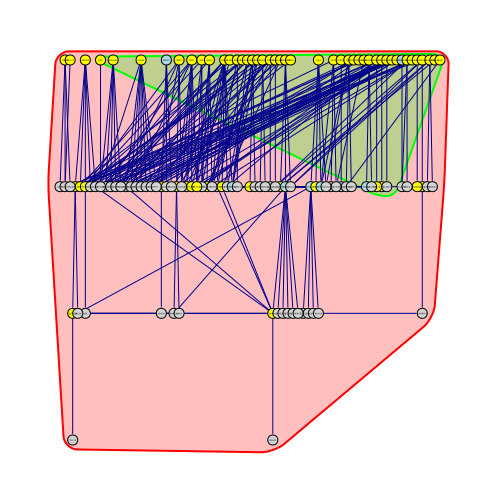

In [199]:
subgr = subgr1.es.select(treatment=1).subgraph()

plot_graph(
    subgr,
    initial='CRISPRi_TF',
    vs_size = 10,
    vs_width = 10,
    vs_label_size = 2,
    geneset=[g for g in subgr.vs['name'] if g in tf_names_all],
    geneset2=[l for l in geneset if l in subgr.vs['name']],
    layout='tree',#)
    # b1=250,b2=250,
)

## a graph representation 

# 

In [191]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-08-16T17:37:59.634844-07:00

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.11.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
blitzgsea: 1.3.34
anndata  : 0.8.0
dask     : 2023.5.0
networkx : 3.1
pandas   : 1.5.3
igraph   : 0.10.4
arboreto : 0.1.6

